Importing packages

In [29]:
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from sksurv.util import Surv
from sksurv.ensemble import GradientBoostingSurvivalAnalysis
from sksurv.metrics import concordance_index_censored
import shap as shap
import time

Loading Google Drive

In [30]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Loading both train and test dataset.

In [31]:
#load dataset
train_data = pd.read_csv("/content/drive/MyDrive/SVC/train_data_p3.csv")
print(train_data.info())
print(train_data.head())
train_data = train_data.drop(columns=['Unnamed: 0'])
#N=350, p=7

test_data = pd.read_csv("/content/drive/MyDrive/SVC/test_data_p3.csv")
print(test_data.info())
print(test_data.head())
test_data = test_data.drop(columns=['Unnamed: 0'])
#n=37, p=7

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 350 entries, 0 to 349
Data columns (total 8 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   Unnamed: 0                   350 non-null    int64  
 1   Self-confidence in quitting  350 non-null    int64  
 2   Intention to quit            350 non-null    int64  
 3   Time to first vape           350 non-null    int64  
 4   Mood trend during challenge  350 non-null    int64  
 5   Average e-liquid per week    350 non-null    float64
 6   Time.elapsed                 350 non-null    float64
 7   status                       350 non-null    int64  
dtypes: float64(2), int64(6)
memory usage: 22.0 KB
None
   Unnamed: 0  Self-confidence in quitting  Intention to quit  \
0           1                            2                  1   
1           2                            2                  1   
2           3                            4                  1   


The 5 predictors are Self-confidence in quitting, Intention to quit, Time to first vape, Mood trend during challenge, and Avergae e-liquid per week.

In [32]:
####Preparing dataset for GBM survival model####
X_train = train_data.drop(['Time.elapsed', 'status'], axis=1)
X_test = test_data.drop(['Time.elapsed', 'status'], axis=1)
y_train = np.array(
    [(bool(e), t) for e, t in zip(train_data['status'], train_data['Time.elapsed'])],
    dtype=[('event', '?'), ('time', '<f8')]
)
y_test = np.array(
    [(bool(e), t) for e, t in zip(test_data['status'], test_data['Time.elapsed'])],
    dtype=[('event', '?'), ('time', '<f8')]
)

In [33]:
###GBM survival with pre-defined best hyperparameters
start_time = time.time()
estimator = GradientBoostingSurvivalAnalysis(n_estimators=200, learning_rate=0.01, max_depth=5, min_samples_leaf=10, random_state=123)
gbm = estimator.fit(X_train, y_train)
end_time = time.time()

training_time = end_time - start_time
print(f"Training time: {training_time:.3f} seconds")

Training time: 1.812 seconds


Calculating risk socre and performance of the model

In [34]:
#performance
risk_scores = gbm.predict(X_test)
c_index = concordance_index_censored(
    y_test["event"],   # boolean event indicator
    y_test["time"],    # time to event or censoring
    risk_scores        # model predictions
)[0]
print("Concordance Index (C-index):", round(c_index, 3))

Concordance Index (C-index): 0.751


Risk stratification

In [35]:
time_point = 7
surv_preds = estimator.predict_survival_function(X_test)
predictions_at_time_point = np.array([1 - s(time_point) for s in surv_preds])
row_id = 11 ##will change depending on the participant whose prediction we need to figure out
pred_relapse_row_id = predictions_at_time_point[row_id]
print(f"Predicted probability of relapse at day {time_point} for row {row_id}: {pred_relapse_row_id*100:.1f}%")

Predicted probability of relapse at day 7 for row 11: 98.7%


In [36]:
#Dividing the participants according to predicted probability of relapse
if pred_relapse_row_id <= 0.25:
    category = "High Probability of Quit Success"
elif 0.25 < pred_relapse_row_id < 0.75:
    category = "Medium Probability of Quit Success"
else:
    category = "Low Probability of Quit Success"

print(f"The individual has a {category} at day {time_point}.")

The individual has a Low Probability of Quit Success at day 7.


Applying SHAP on the model

Time needed for SHAP: 1.491 seconds


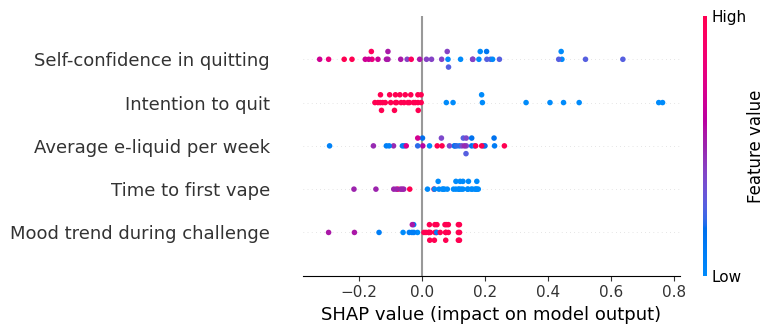

In [37]:
###SHAP analysis
start_time = time.time()
explainer = shap.Explainer(estimator.predict, X_train)
shap_values = explainer(X_test)
end_time = time.time()

shap_time = end_time - start_time
print(f"Time needed for SHAP: {shap_time:.3f} seconds")

matplotlib.rcParams.update({'font.size': 12})
shap.summary_plot(shap_values, X_test)
plt.clf()

<Figure size 640x480 with 0 Axes>

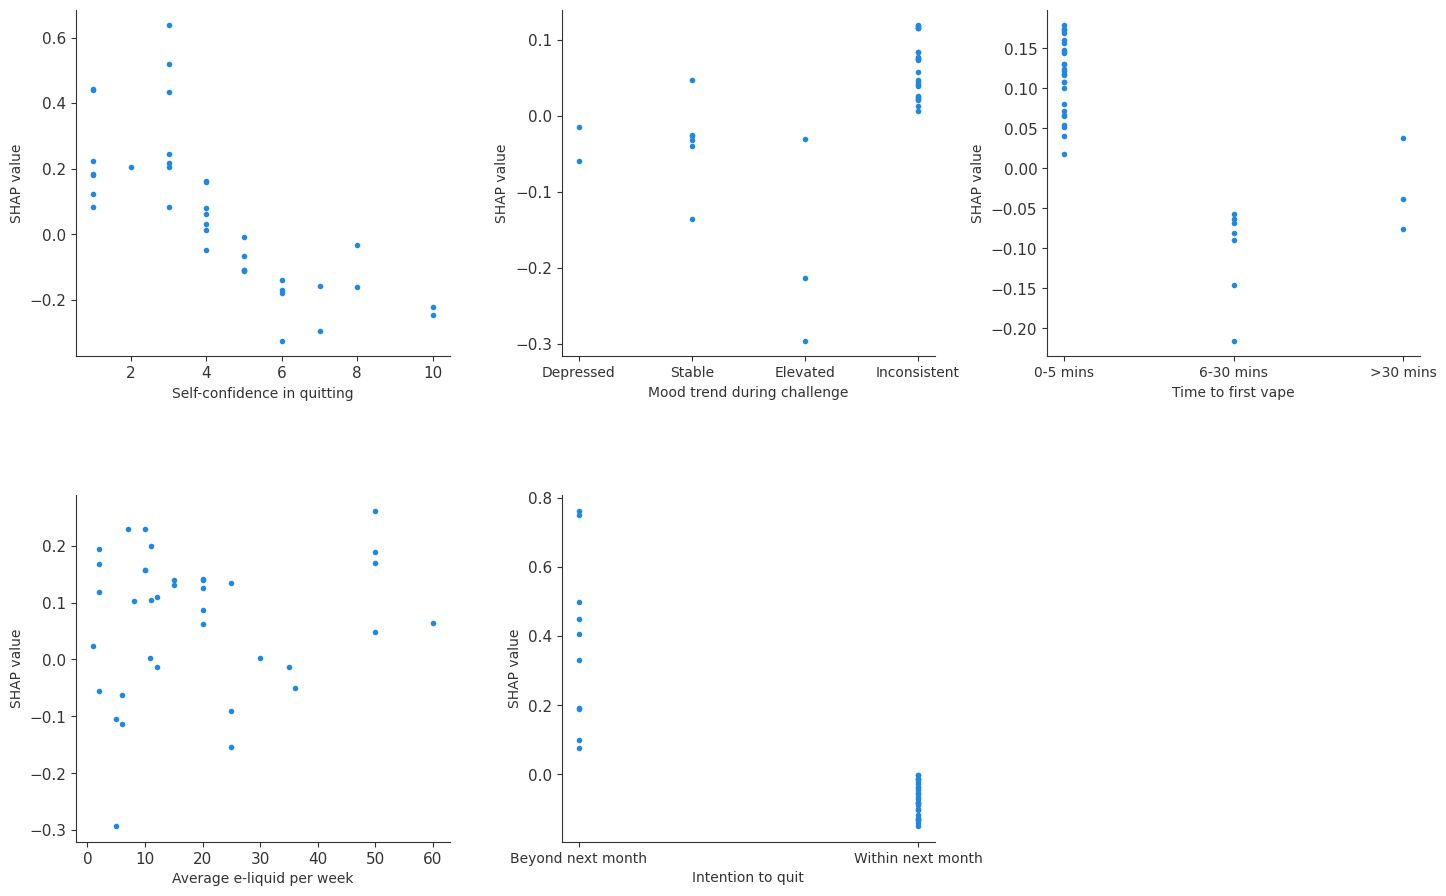

In [38]:
##SHAP Dependence plots
fig, axes = plt.subplots(2, 3, figsize=(15, 10))
axes = axes.flatten()

shap.dependence_plot("Self-confidence in quitting", shap_values.values, X_test, interaction_index=None, ax=axes[0], show= False)
axes[0].set_xlabel("Self-confidence in quitting", fontsize=10)
axes[0].set_ylabel("SHAP value", fontsize=10)

shap.dependence_plot("Mood trend during challenge", shap_values.values, X_test,
                     interaction_index=None, ax=axes[1], show=False)
axes[1].set_xticks([0, 1, 2, 3])
axes[1].set_xticklabels(["Depressed", "Stable", "Elevated", "Inconsistent"], fontsize=10)
axes[1].set_xlabel("Mood trend during challenge", fontsize=10)
axes[1].set_ylabel("SHAP value", fontsize=10)

shap.dependence_plot("Time to first vape", shap_values.values, X_test, interaction_index=None, ax=axes[2], show= False)
axes[2].set_xticks([0, 1, 2])
axes[2].set_xticklabels(["0-5 mins", "6-30 mins", ">30 mins"], fontsize=10)
axes[2].set_xlabel("Time to first vape", fontsize=10)
axes[2].set_ylabel("SHAP value", fontsize=10)

shap.dependence_plot("Average e-liquid per week", shap_values.values, X_test,
                     interaction_index=None, ax=axes[3], show=False)
axes[3].set_xlabel("Average e-liquid per week", fontsize=10)
axes[3].set_ylabel("SHAP value", fontsize=10)

shap.dependence_plot("Intention to quit", shap_values.values, X_test, interaction_index=None, ax=axes[4], show= False)
axes[4].set_xticks([0, 1])
axes[4].set_xticklabels(["Beyond next month", "Within next month"], fontsize=10)
axes[4].set_xlabel("Intention to quit", fontsize=10)
axes[4].set_ylabel("SHAP value", fontsize=10)

axes[5].axis("off")

plt.tight_layout()
plt.subplots_adjust(left=0.08, bottom=0.15, hspace=0.4, wspace=0.3)
plt.show()

Demonstrating individual probability through SHAP Waterfall plot

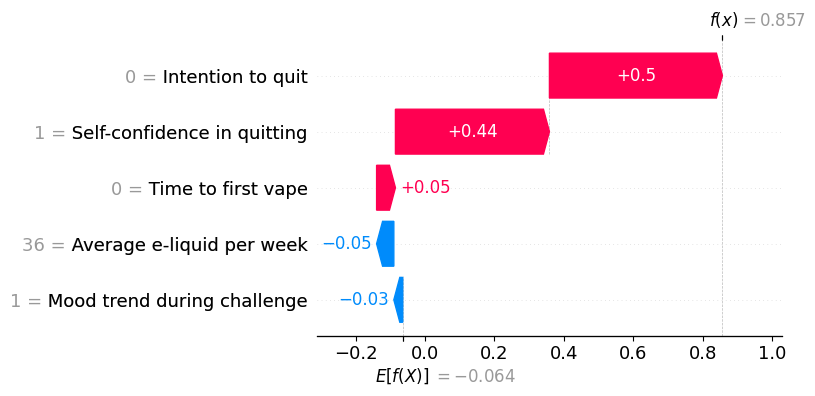

In [39]:
matplotlib.rcParams.update({'font.size': 8})
sample_index = 11
shap.plots.waterfall(shap_values[sample_index], max_display=15, show=False)
plt.tight_layout()
plt.show()